# Laboratorio de regresión lineal Machine Learning


Alejandro Suárez  
Daniel Díaz

## Se importan las librerías

In [364]:
import scipy.io
import matplotlib.pyplot as plt
from scipy.special import expit
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import r2_score
%matplotlib inline

## Carga de datos

In [3]:
mat = scipy.io.loadmat('ejemplo_regresion.mat')
x = mat.get('x')
y = mat.get('y')
t = mat.get('t')
consumo_mat = scipy.io.loadmat('consumoDB.mat')
hrsignal_mat = scipy.io.loadmat('HRsignal.mat')

## Ejemplo de Regresión

### Visualizamos los datos de entrada

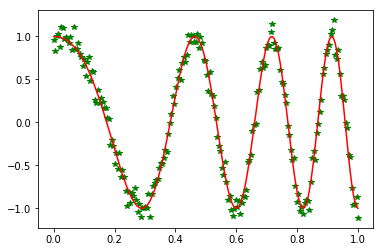

In [4]:
plt.figure
plt.plot(x, t, '*g')
plt.plot(x, y, '-r')

### Definicion de funciones

In [409]:
def expFunction(x, miu, s):
    return np.exp(-np.power((x - miu), 2)/(2*s*s))

def BFunction(xi, M, Fbase, x_mean):
    phiXn = np.zeros(M)
    idP = np.linspace(0, M - 1, M)
    if(Fbase == 'poly'):
        phiXn = np.power(xi, idP)
    if(Fbase == 'exp'):
        idP = np.linspace(-2, 2, M)
        s = 0.005
        phiXn = expFunction(xi, idP, s)
    if(Fbase == 'sigmod'):
        s = 0.005
        idP = np.linspace(-2, 2, M)
        a = (xi - idP) / s
        phiXn = expit(a)
    return phiXn
# se adapta mejor al rango de los datos, cambiar x_mean por x_min  a x_max
# si el M es muy alto, reduciendo el s se puede ajustar
# no he probado moviendo el dato de regularización
# la poly para muchos datos no da porque crece mucho y se vuelve inestable


def MBFunction(x_vect, M, Fbase):
    N = np.size(x_vect)
    PHIX = np.zeros([N,M])
    for i in range(0,N):
        PHIX[i,:] = BFunction(x_vect[i],M,Fbase, np.mean(x_vect))
    return PHIX

def calcWml(mPHIXT, t):
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX))
    return mPHIXT_pw2_inv.dot(mPHIXT).dot(t)

def calcWmlReg(mPHIX, t):
    L = np.exp(-30)
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX) + L*np.eye(M))
    return mPHIXT_pw2_inv.dot(mPHIXT.dot(t))

def calcYEst(mPHIX, t):
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX))
    w_ml = mPHIXT_pw2_inv.dot(mPHIXT).dot(t)
    return mPHIX.dot(w_ml)

def calcYEstReg(mPHIX, t):
    L = np.exp(-30)
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX) + L*np.eye(M))
    w_ml = mPHIXT_pw2_inv.dot(mPHIXT.dot(t))
    return mPHIX.dot(w_ml)


fNames = ['poly', 'sigmod', 'exp']

In [6]:
iters = 100
M = 30
N = x.shape[0]
mPHIX = MBFunction(x, M, 'sigmod')
mPHIXT = mPHIX.T
alpha = np.random.rand()
beta = np.random.rand()
invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
Sn = np.linalg.inv(invSn)
mn = beta * (Sn @ mPHIXT @ t)

yEst = mPHIX.dot(mn)
error = np.zeros(iters)
error[0] = np.squeeze(0.5 * ((t - yEst).T)@(t - yEst))
print("MSE = ", error[0])

MSE =  44.87584590661335


In [7]:
# Calculamos autovalores de PHIT*PHI
rho = np.real(np.linalg.eigvals(mPHIXT@mPHIX))
Lambda = beta * rho
Gamma = np.sum(Lambda / (alpha + Lambda))
def half_ln(N, X):
  return 0.5 * N * np.log(X + 1e-20)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi

#def bayesian():
    #iniciamos el proceso iterativo
    #para la busqueda de alpha y beta
logEv = np.zeros(iters)
error = np.zeros(iters)

for it in range(1, iters):
  alpha = Gamma / ((mn.T)@mn)
  norm_t_phi = t - mPHIX@mn
  invBeta = 1./(N - Gamma) * ((norm_t_phi.T)@(norm_t_phi))
  beta = 1./invBeta
  #Se actualizan los parametros del posterior
  invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
  Sn = np.linalg.inv(invSn)
  mn = beta * (Sn @ mPHIXT @ t)
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))

  #Se calcula el error
  yEst = mPHIX.dot(mn)
  error[it] = np.squeeze((0.5 * ((t - yEst).T)@(t - yEst)))
  logEv[it] = logEvi(invSn, alpha, beta, 2 * error[it])

Text(0, 0.5, 'logEv')

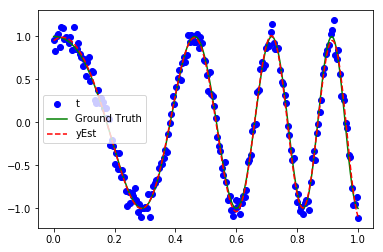

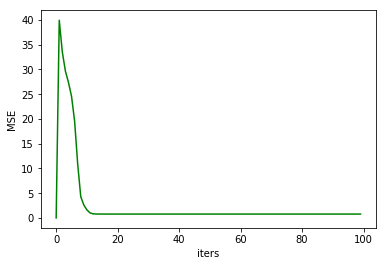

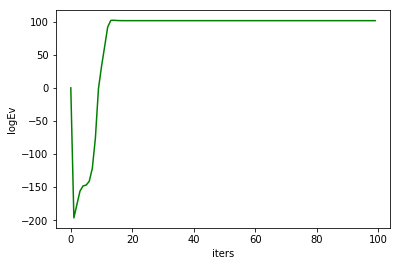

In [8]:
plt.plot(x,t,'ob')

plt.plot(x,y,'-g')
plt.plot(x,yEst,'--r')
plt.legend(('t','Ground Truth','yEst'))
plt.figure(2)
plt.plot(error, '-g')
plt.xlabel('iters')
plt.ylabel('MSE')

plt.figure(3)
plt.plot(logEv, '-g')
plt.xlabel('iters')
plt.ylabel('logEv')

In [9]:
M=30
N = x.shape[0]
mPHIX = MBFunction(x, M, 'poly')
w_ml = calcWml(mPHIX, t)
yEst = mPHIX.dot(w_ml)

w_mlReg = calcWmlReg(mPHIX, t)
yEstReg = mPHIX.dot(w_mlReg)

aux = t - mPHIX.dot(w_ml)
beta_ml = (1. / N) * aux.T.dot(aux)
print(beta_ml)

[[0.00834552]]


MSE =  0.0013406126215430557
MSE reg =  0.0014783481129183444


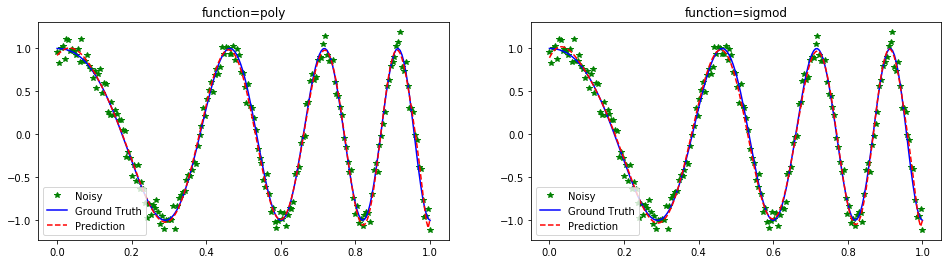

In [10]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (25,4)
)

import pylab as pb
for idx, pred in enumerate([yEst, yEstReg]):
  plt.subplot(1, 3, idx + 1)
  #upper = pred + 2 * np.sqrt(beta_ml)
  #lower = pred - 2 * np.sqrt(beta_ml)
  plt.plot(x, t, '*g')
  plt.plot(x, y, '-b')
  plt.plot(x, pred, '--r')
  #pb.plot(x,upper,color="#204a87",linewidth=0.2)
  #pb.plot(x,lower,color="#204a87",linewidth=0.2)
  #pb.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color="#729fcf",alpha=0.3)

  plt.legend(('Noisy','Ground Truth','Prediction'))
  plt.title(f'function={fNames[idx]}')

diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))
diff = y - yEstReg
error = 1. / N * diff.T.dot(diff)
print("MSE reg = ", np.squeeze(error))

In [11]:
M=22
mPHIX = MBFunction(x, M, 'sigmod')
yEst = calcYEst(mPHIX, t)
yEstReg = calcYEstReg(mPHIX, t)

MSE =  0.0007540139208327477
MSE reg =  0.0007517538488889162


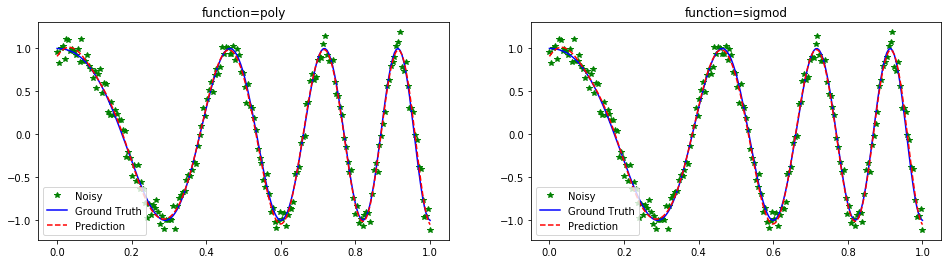

In [12]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (25,4)
)

for idx, pred in enumerate([yEst, yEstReg]):
  plt.subplot(1, 3, idx + 1)
  plt.plot(x, t, '*g')
  plt.plot(x, y, '-b')
  plt.plot(x, pred, '--r')
  plt.legend(('Noisy','Ground Truth','Prediction'))
  plt.title(f'function={fNames[idx]}')

diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))
diff = y - yEstReg
error = 1. / N * diff.T.dot(diff)
print("MSE reg = ", np.squeeze(error))

In [13]:
M=20
N = x.shape[0]
mPHIX = MBFunction(x, M, 'exp')
yEst = calcYEst(mPHIX, t)
yEstReg = calcYEstReg(mPHIX, t)

MSE =  0.29832678091028003
MSE reg =  0.29832663096639145


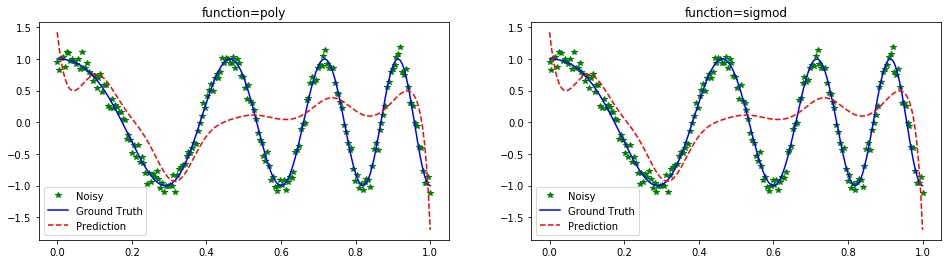

In [14]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (25,4)
)

for idx, pred in enumerate([yEst, yEstReg]):
  plt.subplot(1, 3, idx + 1)
  plt.plot(x, t, '*g')
  plt.plot(x, y, '-b')
  plt.plot(x, pred, '--r')
  plt.legend(('Noisy','Ground Truth','Prediction'))
  plt.title(f'function={fNames[idx]}')

diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))
diff = y - yEstReg
error = 1. / N * diff.T.dot(diff)
print("MSE reg = ", np.squeeze(error))

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


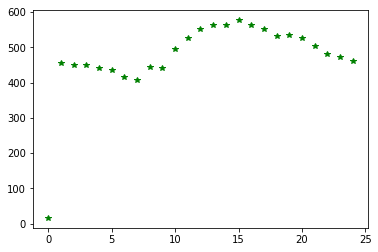

In [212]:
consumo_x = consumo_mat.get('x')
consumo_t = consumo_mat.get('t')
std_consumo_x = preprocessing.scale(consumo_x)
std_consumo_t = preprocessing.scale(consumo_t)
plt.figure
plt.plot(consumo_x, consumo_t, '*g')

In [375]:
M=16
N = consumo_x.shape[0]
mPHIX = MBFunction(std_consumo_x, M, 'poly')
yEst = calcYEst(mPHIX, std_consumo_t)

16 & 0.9975787251914151


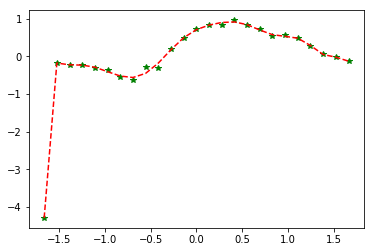

In [376]:
plt.plot(std_consumo_x, std_consumo_t, '*g')
plt.plot(std_consumo_x, yEst, '--r')
error = np.squeeze((0.5 * ((std_consumo_t - yEst).T)@(std_consumo_t - yEst)))

In [ ]:
# consumo poly
16 & 0.9975787251914151
17 & 0.9977682538103615
18 & 0.9977699824412719
19 & 0.9976569912442416
20 & 0.9976389179065019

# consumo bay sigmoid
19 & 0.993322154347893
20 & 0.9950552565316867
21 & 0.9978851602303755
22 & 0.9977264941165079
23 & 0.9964586517104135

# consumo bay pol
18 & 0.9961990950786741
19 & 0.995819245403291
20 & 0.9956068053426177
21 & 0.9961470035789873
22 & 0.9958114906905138


In [399]:
iters = 50
M = 22
N = std_consumo_x.shape[0]
mPHIX = MBFunction(std_consumo_x, M, 'poly')
mPHIXT = mPHIX.T
alpha = np.random.rand()
beta = np.random.rand()
invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
Sn = np.linalg.inv(invSn)
mn = beta * (Sn @ mPHIXT @ std_consumo_t)

yEst = mPHIX.dot(mn)
error = np.zeros(iters)
error[0] = np.squeeze(0.5 * ((std_consumo_t - yEst).T)@(std_consumo_t - yEst))
print("MSE = ", error[0])

MSE =  0.46032225339983107


In [400]:
# Calculamos autovalores de PHIT*PHI
rho = np.real(np.linalg.eigvals(mPHIXT@mPHIX))
Lambda = beta * rho
Gamma = np.sum(Lambda / (alpha + Lambda))
def half_ln(N, X):
  return 0.5 * N * np.log(X + 1e-20)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi

logEv = np.zeros(iters)
error = np.zeros(iters)

for it in range(1, iters):
  alpha = Gamma / ((mn.T)@mn)
  norm_t_phi = std_consumo_t - mPHIX@mn
  invBeta = 1./(N - Gamma) * ((norm_t_phi.T)@(norm_t_phi))
  beta = 1./invBeta
  #Se actualizan los parametros del posterior
  invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
  Sn = np.linalg.inv(invSn)
  mn = beta * (Sn @ mPHIXT @ std_consumo_t)
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))

  #Se calcula el error
  yEst = mPHIX.dot(mn)
  error[it] = np.squeeze((0.5 * ((std_consumo_t - yEst).T)@(std_consumo_t - yEst)))
  logEv[it] = logEvi(invSn, alpha, beta, 2 * error[it])
    
#print("MSE = ", error)
print(M, "&", r2_score(std_consumo_t, yEst))

22 & 0.9958114906905138


21.94764347

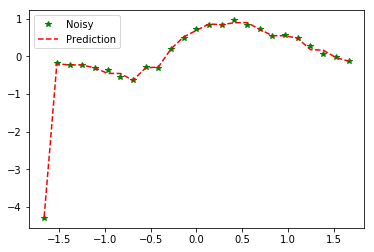

In [363]:
plt.plot(std_consumo_x, std_consumo_t, '*g')
plt.plot(std_consumo_x, yEst, '--r')
plt.legend(('Noisy','Prediction'))


In [248]:
M=25
mPHIX = MBFunction(consumo_x, M, 'exp')
yEst = calcYEst(mPHIX, consumo_t)

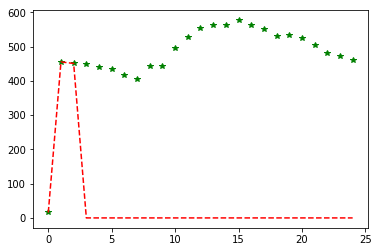

In [21]:
plt.plot(consumo_x, consumo_t, '*g')
plt.plot(consumo_x, yEst, '--r')

(6528, 1)

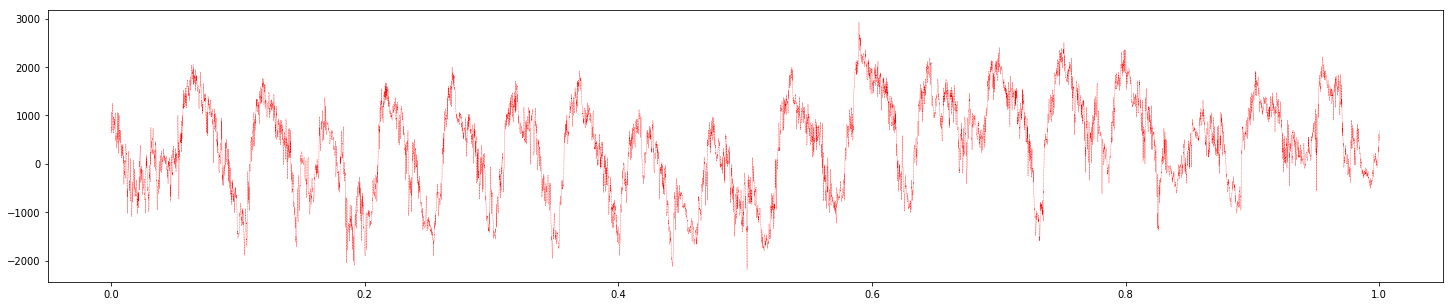

In [63]:
hrsignal_mat = scipy.io.loadmat('HRsignal.mat')
hr_t = hrsignal_mat.get('HR')
hr_x = hrsignal_mat.get('x').T

std_x = preprocessing.scale(hr_x)
std_t = preprocessing.scale(hr_t)

plt.figure(figsize=(25,5))
plt.plot(hr_x, hr_t,  linestyle='--' , linewidth=0.3, color='red')
hr_t.shape

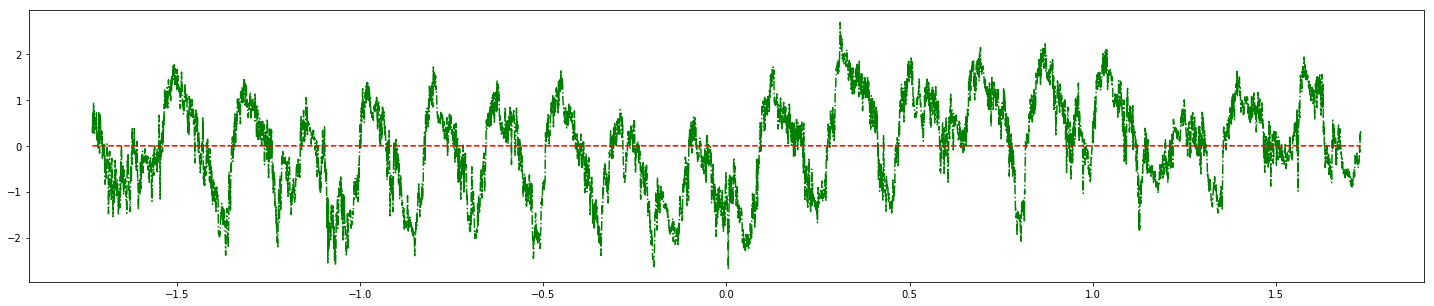

In [412]:
M=500
mPHIX = MBFunction(std_x, M, 'sigmoid')
yEst = calcYEst(mPHIX, std_t)
plt.figure(figsize=(25,5))
plt.plot(std_x,std_t, '-.g')
plt.plot(std_x, yEst, '--r')

MSE =  3263.999999999999
400 & 0.0


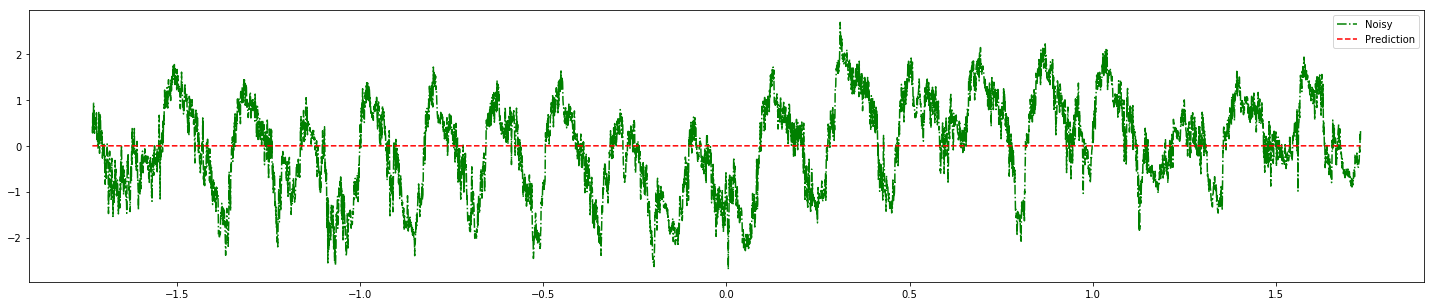

In [410]:
M=400
N = std_x.shape[0]
mPHIX = MBFunction(std_x, M, 'sigmoid')
yEst = calcYEstReg(mPHIX, std_t)
plt.figure(figsize=(25,5))
plt.plot(std_x, std_t, '-.g')
plt.plot(std_x, yEst, '--r')
plt.legend(('Noisy','Prediction'))
diff = std_t - yEst
error = np.squeeze((0.5 * ((std_t - yEst).T)@(std_t - yEst)))
print("MSE = ", np.squeeze(error))
print(M, "&", r2_score(std_t, yEst))

In [406]:
iters = 50
M = 800
N = std_x.shape[0]
mPHIX = MBFunction(std_x, M, 'sigmod')
mPHIXT = mPHIX.T
alpha = np.random.rand()
beta = np.random.rand()
invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
Sn = np.linalg.inv(invSn)
mn = beta * (Sn @ mPHIXT @ std_t)

yEst = mPHIX.dot(mn)
error = np.zeros(iters)
error[0] = np.squeeze(0.5 * ((std_t - yEst).T)@(std_t - yEst))
print("MSE = ", error[0])

MSE =  213.75942730167202


In [407]:
# Calculamos autovalores de PHIT*PHI
rho = np.real(np.linalg.eigvals(mPHIXT@mPHIX))
Lambda = beta * rho
Gamma = np.sum(Lambda / (alpha + Lambda))
def half_ln(N, X):
  return 0.5 * N * np.log(X + 1e-20)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi

#def bayesian():
    #iniciamos el proceso iterativo
    #para la busqueda de alpha y beta
logEv = np.zeros(iters)
error = np.zeros(iters)

for it in range(1, iters):
  alpha = Gamma / ((mn.T)@mn)
  norm_t_phi = std_t - mPHIX@mn
  invBeta = 1./(N - Gamma) * ((norm_t_phi.T)@(norm_t_phi))
  beta = 1./invBeta
  #Se actualizan los parametros del posterior
  invSn = alpha * np.eye(M) + beta * (mPHIXT @ mPHIX)
  Sn = np.linalg.inv(invSn)
  mn = beta * (Sn @ mPHIXT @ std_t)
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))

  #Se calcula el error
  yEst = mPHIX.dot(mn)
  error[it] = np.squeeze((0.5 * ((std_t - yEst).T)@(std_t - yEst)))
  logEv[it] = logEvi(invSn, alpha, beta, 2 * error[it])
    
print("MSE = ", error[iters - 1])

F:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


MSE =  161.99325567177445


[  0.         191.99420562 181.08816212 174.36779173 170.11065029
 167.38954231 165.62512256 164.46196301 163.68379531 163.15711524
 162.79756036 162.55056642 162.38014297 162.2621848  162.18036116
 162.12351565 162.08398084 162.05646459 162.03730325 162.02395509
 162.01465414 162.0081721  162.0036541  162.00050473 161.99830929
 161.99677875 161.99571173 161.99496782 161.99444919 161.99408761
 161.99383551 161.99365975 161.9935372  161.99345178 161.99339223
 161.9933507  161.99332174 161.99330154 161.99328746 161.99327766
 161.9932708  161.99326603 161.99326271 161.99326038 161.99325877
 161.99325766 161.99325686 161.99325632 161.99325593 161.99325567]


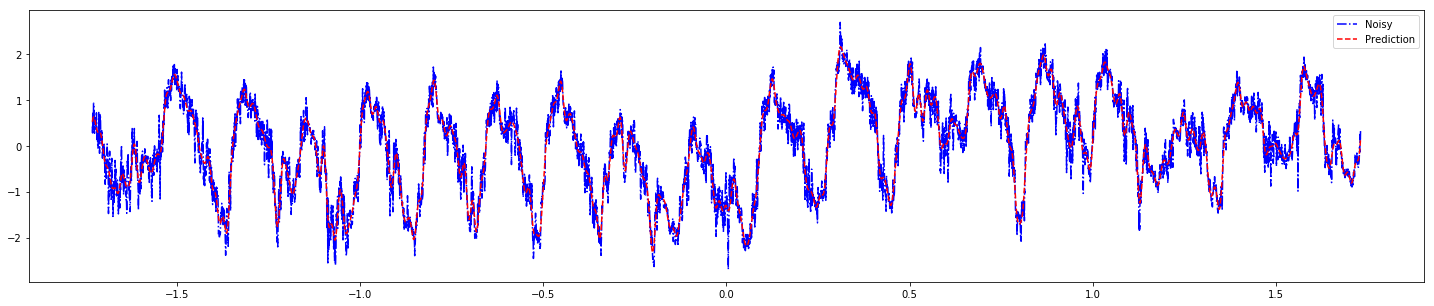

In [408]:
print(error)
plt.figure(figsize=(25,5))
plt.plot(std_x, std_t,'-.b')
plt.plot(std_x,yEst,'--r')
plt.legend(('t', 'yEst'))
plt.legend(('Noisy','Prediction'))